<a href="https://colab.research.google.com/github/Saintone11/DataScience/blob/main/%EC%A0%84%EB%A0%A5%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

%cd drive/MyDrive
zip = zipfile.ZipFile('open.zip')
zip.extractall()
zip.close()

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [ ]:
import pandas as pd
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
building_info = pd.read_csv("building_info.csv")

In [ ]:
train = train.rename(columns={
    '건물번호': 'bnum',
    '일시': 'date',
    '기온(C)': 'temp',
    '강수량(mm)': 'rain',
    '풍속(m/s)': 'wind',
    '습도(%)': 'hum',
    '일조(hr)': 'hr',
    '일사(MJ/m2)': 'MJ',
    '전력소비량(kWh)': 'power'
})
train.drop('num_date_time', axis = 1, inplace=True)
train.head()

,bnum,date,temp,rain,wind,hum,hr,MJ,power
0,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [ ]:
test = test.rename(columns={
    '건물번호': 'bnum',
    '일시': 'date',
    '기온(C)': 'temp',
    '강수량(mm)': 'rain',
    '풍속(m/s)': 'wind',
    '습도(%)': 'hum',
    '일조(hr)': 'sun',
    '일사(MJ/m2)': 'solar',
    '전력소비량(kWh)': 'power'
})
test.drop('num_date_time', axis = 1, inplace=True)
test.head()

,bnum,date,temp,rain,wind,hum
0,1,20220825 00,23.5,0.0,2.2,72
1,1,20220825 01,23.0,0.0,0.9,72
2,1,20220825 02,22.7,0.0,1.5,75
3,1,20220825 03,22.1,0.0,1.3,78
4,1,20220825 04,21.8,0.0,1.0,77


In [ ]:
train.head()

,bnum,date,temp,rain,wind,hum,power
0,1,20220601 00,18.6,0.0,0.9,42.0,1085.28
1,1,20220601 01,18.0,0.0,1.1,45.0,1047.36
2,1,20220601 02,17.7,0.0,1.5,45.0,974.88
3,1,20220601 03,16.7,0.0,1.4,48.0,953.76
4,1,20220601 04,18.4,0.0,2.8,43.0,986.40


<Axes: >

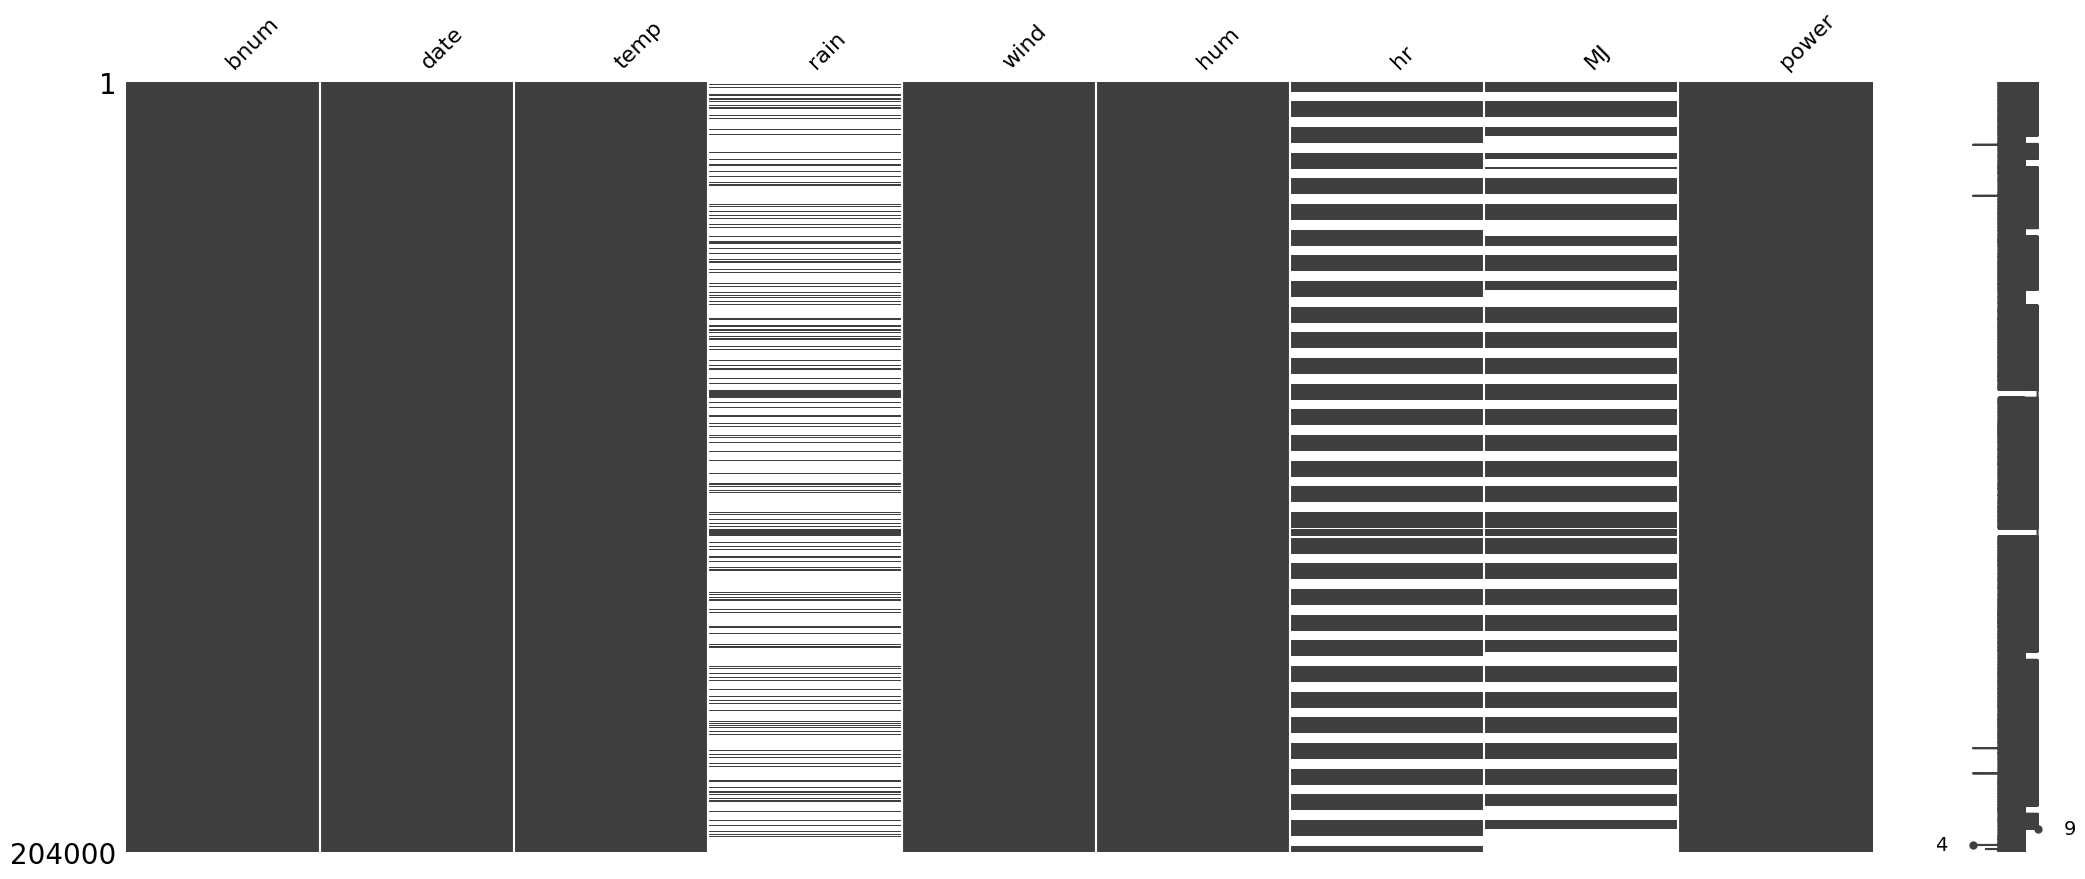

In [ ]:
import missingno as msno
msno.matrix(train)

In [ ]:
print(len(train[train['solar'] == '-']))
print(len(train[train['ess'] == '-']))
print(len(train[train['pcs'] == '-']))

130560
193800
193800


In [ ]:
train = train.drop(['hr','MJ'], axis=1)

In [ ]:
train['rain'].fillna(0, inplace=True)

<ipython-input-104-f7d935af24f2>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_power = train.groupby(train['datetime'].dt.date).sum()['power']


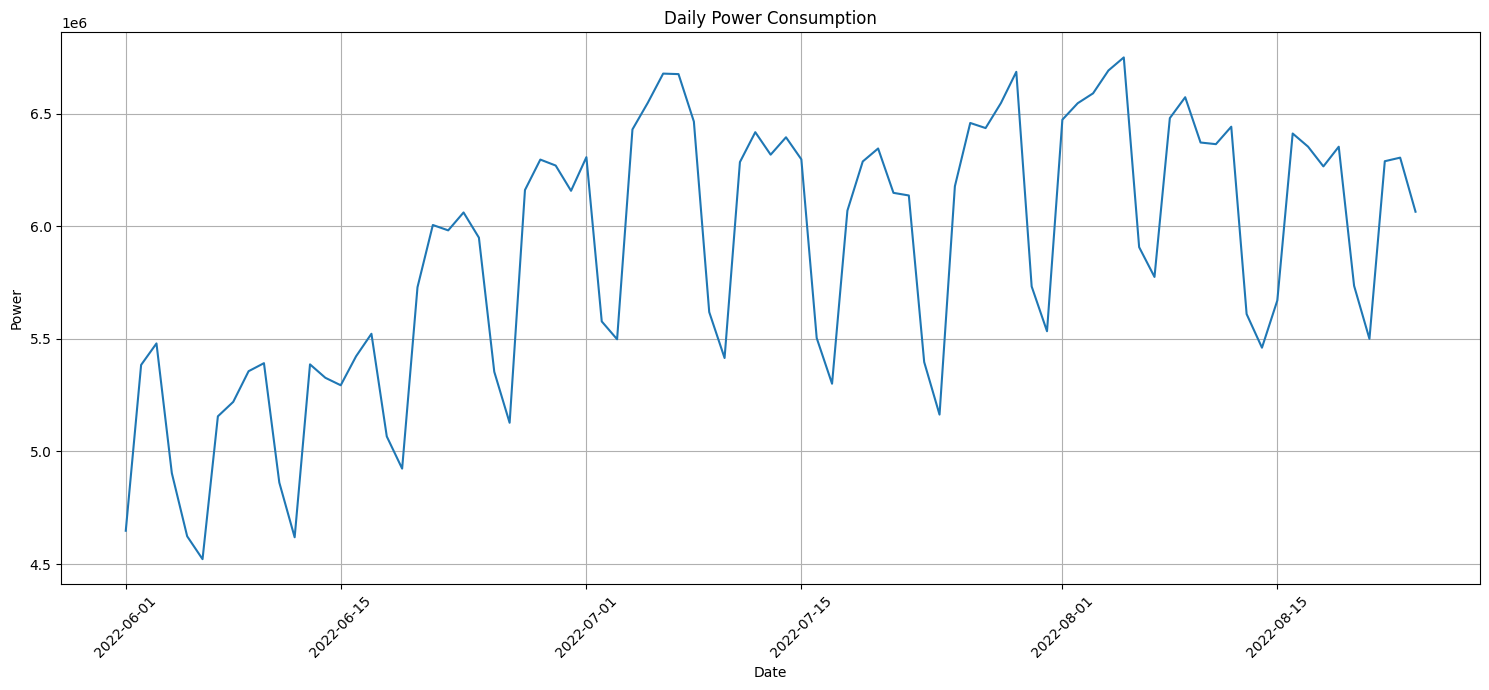

In [ ]:
import matplotlib.pyplot as plt

train['datetime'] = pd.to_datetime(train['date'], format='%Y%m%d %H')

# 일자별로 power 값을 합산
daily_power = train.groupby(train['datetime'].dt.date).sum()['power']

# 시각화
plt.figure(figsize=(15, 7))
daily_power.plot(kind='line')
plt.title("Daily Power Consumption")
plt.ylabel("Power")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# date 컬럼을 datetime 형태로 변환
train['datetime'] = pd.to_datetime(train['date'], format='%Y%m%d %H')

# 월, 일, 시를 각각의 컬럼으로 추출
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['weekday'] = train['datetime'].dt.weekday

# 공휴일 변수 초기화
train['holiday'] = 0

# 6월 3일이 토요일이므로, 해당 날짜의 weekday 값은 5입니다.
# 따라서 6월 3일의 요일을 기준으로 나머지 날짜의 요일을 조정합니다.
train['weekday'] = (train['weekday'] + 1) % 7

# 조정된 요일을 기준으로 토요일 및 일요일을 공휴일로 표시
train.loc[train['weekday'] >= 5, 'holiday'] = 1

# 특정 공휴일을 공휴일로 표시
train.loc[(train['month'] == 6) & (train['day'] == 6), 'holiday'] = 1
train.loc[(train['month'] == 8) & (train['day'] == 15), 'holiday'] = 1

# 각 월의 일 수
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# 월과 일 데이터를 합쳐서 '일'로 변환
train['day_of_year'] = train['month'].apply(lambda x: sum(days_in_month[:x-1])) + train['day']

#시간주기데이터로변환
train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)
train['sin_week'] = np.sin(2*np.pi*train.weekday/7)
train['cos_week'] = np.cos(2*np.pi*train.weekday/7)

train['THI'] = 9/5*train['temp'] - 0.55*(1-train['hum']/100)*(9/5*train['hum']-26)+32

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            sum_val = np.sum([max(0, x-24) for x in xs[:(i+1)]])
        else:
            sum_val = np.sum([max(0, x-24) for x in xs[(i-11):(i+1)]])
        ys.append(sum_val)
    return np.array(ys)

cdhs = np.array([])
for bnum in range(1,101,1):
    temp = train[train['bnum'] == bnum]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

# 원래의 date와 datetime, weekday 컬럼 삭제
train = train.drop(columns=['hour','date', 'datetime', 'weekday','day'])
train.head(20)

,bnum,temp,rain,wind,hum,power,month,holiday,day_of_year,sin_time,cos_time,sin_week,cos_week,THI,CDH
0,1,18.6,0.0,0.9,42.0,1085.28,6,0,152,0.000000e+00,1.000000e+00,0.433884,-0.900969,49.6576,0.0
1,1,18.0,0.0,1.1,45.0,1047.36,6,0,152,2.588190e-01,9.659258e-01,0.433884,-0.900969,47.7625,0.0
2,1,17.7,0.0,1.5,45.0,974.88,6,0,152,5.000000e-01,8.660254e-01,0.433884,-0.900969,47.2225,0.0
3,1,16.7,0.0,1.4,48.0,953.76,6,0,152,7.071068e-01,7.071068e-01,0.433884,-0.900969,44.7856,0.0
4,1,18.4,0.0,2.8,43.0,986.40,6,0,152,8.660254e-01,5.000000e-01,0.433884,-0.900969,49.0061,0.0
5,1,17.2,0.0,2.1,46.0,1087.20,6,0,152,9.659258e-01,2.588190e-01,0.433884,-0.900969,46.0904,0.0
6,1,16.3,0.0,1.0,50.0,1314.72,6,0,152,1.000000e+00,6.123234e-17,0.433884,-0.900969,43.7400,0.0
7,1,17.4,0.0,1.3,50.0,1684.80,6,0,152,9.659258e-01,-2.588190e-01,0.433884,-0.900969,45.7200,0.0
8,1,20.6,0.0,1.8,44.0,1976.16,6,0,152,8.660254e-01,-5.000000e-01,0.433884,-0.900969,52.6944,0.0
9,1,23.2,0.0,1.7,41.0,2289.12,6,0,152,7.071068e-01,-7.071068e-01,0.433884,-0.900969,58.2489,0.0


In [ ]:
# date 컬럼을 datetime 형태로 변환
test['datetime'] = pd.to_datetime(test['date'], format='%Y%m%d %H')

# 월, 일, 시를 각각의 컬럼으로 추출
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['weekday'] = test['datetime'].dt.weekday

# 공휴일 변수 초기화
test['holiday'] = 0

# 6월 3일이 토요일이므로, 해당 날짜의 weekday 값은 5입니다.
# 따라서 6월 3일의 요일을 기준으로 나머지 날짜의 요일을 조정합니다.
test['weekday'] = (test['weekday'] + 1) % 7

# 조정된 요일을 기준으로 토요일 및 일요일을 공휴일로 표시
test.loc[test['weekday'] >= 5, 'holiday'] = 1

# 특정 공휴일을 공휴일로 표시
test.loc[(test['month'] == 6) & (test['day'] == 6), 'holiday'] = 1
test.loc[(test['month'] == 8) & (test['day'] == 15), 'holiday'] = 1

# 각 월의 일 수
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# 월과 일 데이터를 합쳐서 '일'로 변환
test['day_of_year'] = test['month'].apply(lambda x: sum(days_in_month[:x-1])) + test['day']

#시간주기데이터로변환
test['sin_time'] = np.sin(2*np.pi*test.hour/24)
test['cos_time'] = np.cos(2*np.pi*test.hour/24)
test['sin_week'] = np.sin(2*np.pi*test.weekday/7)
test['cos_week'] = np.cos(2*np.pi*test.weekday/7)

test['THI'] = 9/5*test['temp'] - 0.55*(1-test['hum']/100)*(9/5*test['hum']-26)+32

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            sum_val = np.sum([max(0, x-24) for x in xs[:(i+1)]])
        else:
            sum_val = np.sum([max(0, x-24) for x in xs[(i-11):(i+1)]])
        ys.append(sum_val)
    return np.array(ys)

cdhs = np.array([])
for bnum in range(1,101,1):
    temp = test[test['bnum'] == bnum]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

# 원래의 date와 datetime, weekday 컬럼 삭제
test = test.drop(columns=['hour','date', 'datetime', 'weekday','day'])
test.head(20)

,bnum,temp,rain,wind,hum,month,holiday,day_of_year,sin_time,cos_time,sin_week,cos_week,THI,CDH
0,1,23.5,0.0,2.2,72,8,0,237,0.000000e+00,1.000000e+00,-0.433884,-0.900969,58.3456,0.0
1,1,23.0,0.0,0.9,72,8,0,237,2.588190e-01,9.659258e-01,-0.433884,-0.900969,57.4456,0.0
2,1,22.7,0.0,1.5,75,8,0,237,5.000000e-01,8.660254e-01,-0.433884,-0.900969,57.8725,0.0
3,1,22.1,0.0,1.3,78,8,0,237,7.071068e-01,7.071068e-01,-0.433884,-0.900969,57.9376,0.0
4,1,21.8,0.0,1.0,77,8,0,237,8.660254e-01,5.000000e-01,-0.433884,-0.900969,56.9961,0.0
5,1,21.6,0.0,1.6,81,8,0,237,9.659258e-01,2.588190e-01,-0.433884,-0.900969,58.3609,0.0
6,1,21.5,0.0,2.3,84,8,0,237,1.000000e+00,6.123234e-17,-0.433884,-0.900969,59.6824,0.0
7,1,21.7,0.0,1.4,83,8,0,237,9.659258e-01,-2.588190e-01,-0.433884,-0.900969,59.5221,0.0
8,1,22.3,0.0,2.2,82,8,0,237,8.660254e-01,-5.000000e-01,-0.433884,-0.900969,60.1016,0.0
9,1,22.7,0.0,2.4,78,8,0,237,7.071068e-01,-7.071068e-01,-0.433884,-0.900969,59.0176,0.0


In [ ]:
train['power'] = np.log(1 + train['power'])

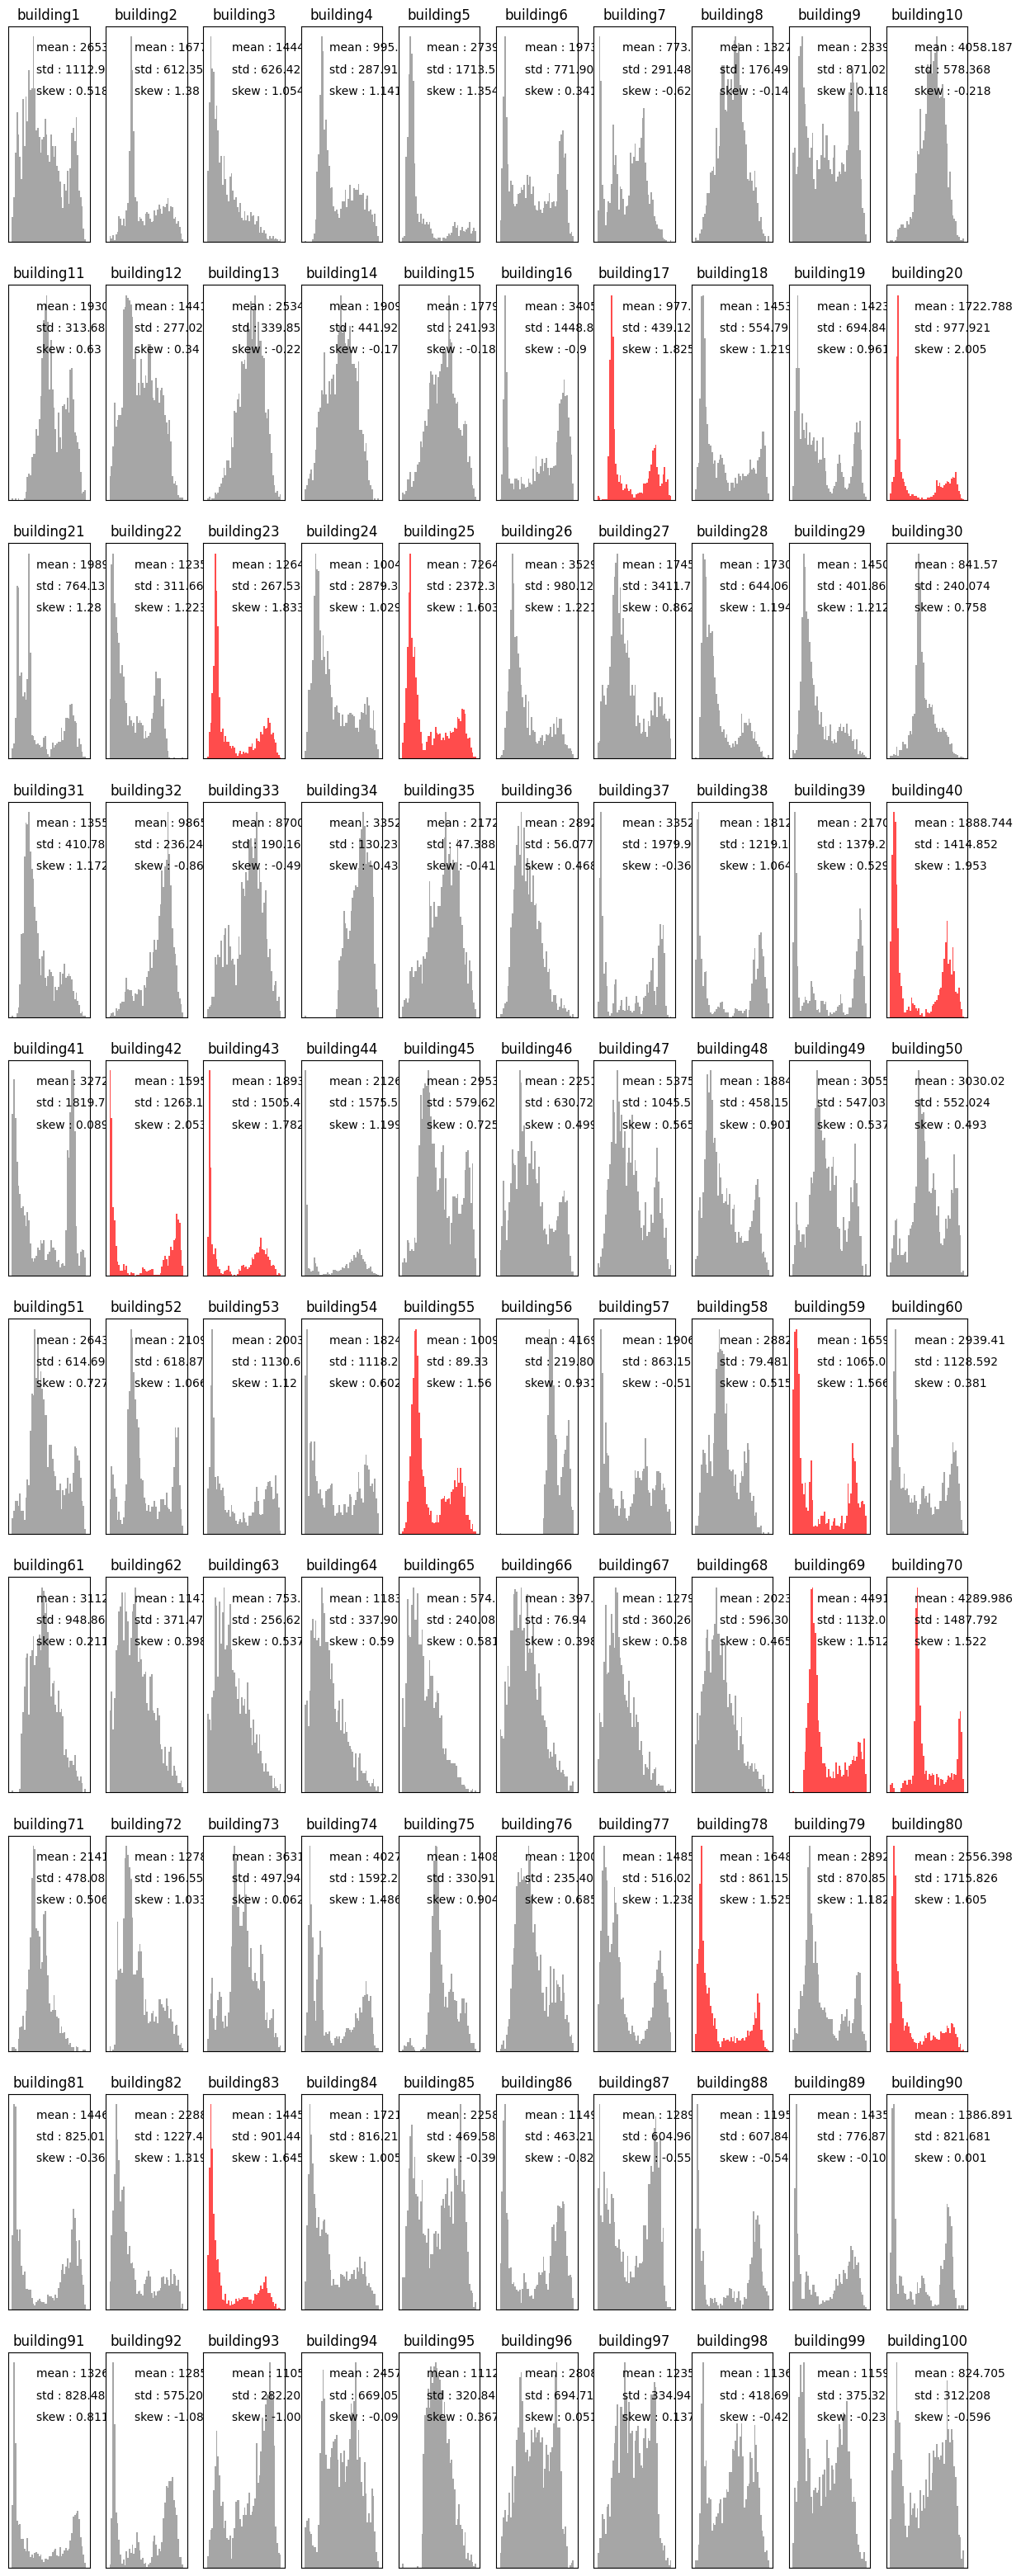

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15, 40))
for num in range(1,101):
    ax = plt.subplot(10, 10, num)
    energy = train.loc[train.bnum == num, 'power'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

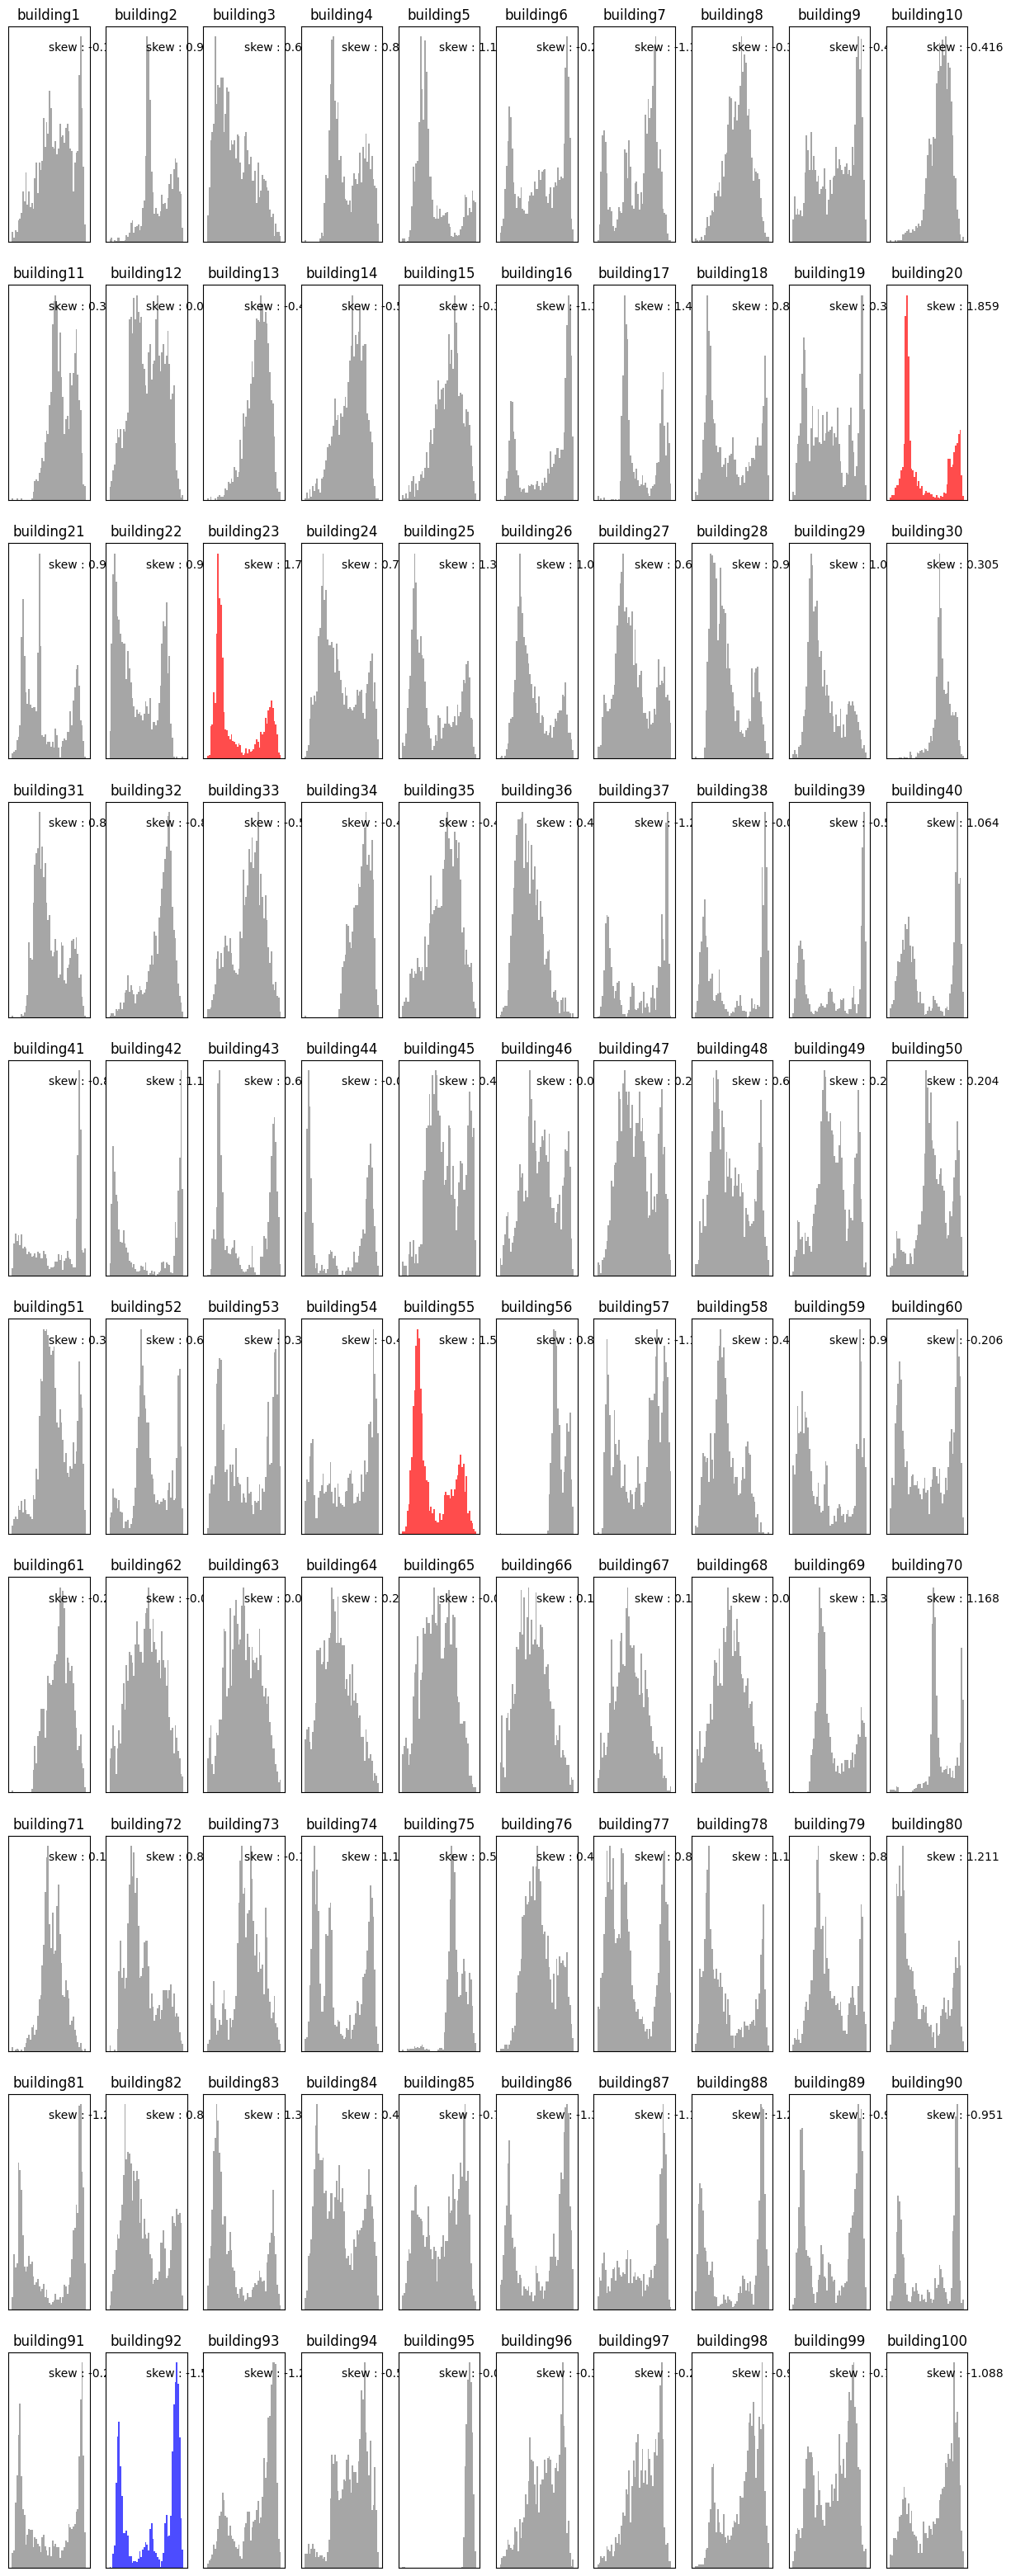

In [ ]:
fig = plt.figure(figsize = (15, 40))
for num in range(1,101):
    ax = plt.subplot(10, 10, num)
    train['power'] = np.log(1 + train['power'])
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.5, 0.9, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

In [ ]:
class WeightedMSEObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        alpha = 2
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
            error = targets[index] - approxes[index]

            if error > 0:  # 과소추정인 경우
                der1 = alpha * error
                der2 = -1 * alpha
            else:
                der1 = error
                der2 = -1

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result

def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [ ]:
!pip install sktime
!pip install catboost
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from catboost import CatBoostRegressor, Pool
from sktime.forecasting.model_selection import temporal_train_test_split
from tqdm import tqdm
df = pd.DataFrame(columns=['learning_rate', 'random_strength', 'l2_leaf_reg'])
preds = np.array([])

grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'random_strength': [0.5, 1, 2, 3],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

for i in tqdm(np.arange(1, 101)):
    y = train.loc[train.bnum == i, 'power']
    x = train.loc[train.bnum == i].drop(['power'], axis=1)

    y_train, y_test, x_train, x_test = temporal_train_test_split(y=y, X=x, test_size=168)

    print(f"Building {i}")
    print(f"y_train shape: {y_train.shape}")
    print(f"x_train shape: {x_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"x_test shape: {x_test.shape}")
    pds = PredefinedSplit(np.append(-np.ones(len(y_train)), np.zeros(len(y_test))))
    gcv = GridSearchCV(estimator=CatBoostRegressor(random_state = 1011),
                       param_grid=grid, cv=pds, refit=True, verbose=True)

    gcv.fit(x_train, y_train, cat_features=['holiday', 'month'])
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)
    pred = best.predict(x_test)
    building = 'building' + str(i)
    print(building + ' || SMAPE: {}'.format(SMAPE(y_test, pred)))
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index=[0])], axis=0)
    df.to_csv('./hyperparameter_catboost.csv', index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Building 1
y_train shape: (1872,)
x_train shape: (1872, 14)
y_test shape: (168,)
x_test shape: (168, 14)
Fitting 1 folds for each of 80 candidates, totalling 80 fits


IndexError: ignored

In [ ]:
!pip install sktime
!pip install catboost
from catboost import CatBoostRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import KFold
from catboost import Pool

# 알파 값 후보
alpha_values = [1.1, 1.5, 2.0, 2.5,3.0,3.5,4.0,5.5,6.0,6.5,7,7.5,8,8.5,9,9.5,10]
cat_features = ['holiday', 'month','bnum']

# 데이터 선택
y = train['power']  # 발전량
X = train.drop(['power'], axis=1)

# 8-Fold CV 설정
kf = KFold(n_splits=8, shuffle=True, random_state=42)

# 각 알파 값에 대한 성능을 저장할 딕셔너리
alpha_scores = {}

for alpha in alpha_values:
    fold_scores = []

    for train_index, valid_index in kf.split(X):
        X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[valid_index]
        y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]

        model = CatBoostRegressor(
            iterations=2000,
            loss_function=WeightedMSEObjective(alpha),
            eval_metric='SMAPE',
            learning_rate=0.1,
            depth=6,
            cat_features=cat_features,
            verbose=200
        )

        model.fit(X_train_fold, y_train_fold, eval_set=(X_valid_fold, y_valid_fold))

        smape_score = model.get_best_score()['validation']['SMAPE']
        fold_scores.append(smape_score)

    # 8-Fold의 평균 성능을 alpha_scores에 저장
    alpha_scores[alpha] = np.mean(fold_scores)

# 결과 출력
for alpha, score in alpha_scores.items():
    print(f"Alpha: {alpha}, Avg SMAPE: {score}")

# 가장 좋은 성능을 보인 알파 값 찾기
best_alpha = min(alpha_scores, key=alpha_scores.get)
print(f"\nBest Alpha: {best_alpha}")

/usr/local/lib/python3.10/dist-packages/catboost/core.py:2268: UserWarning: Can't optimze method "calc_ders_range" because self argument is used
  _check_train_params(params)


0:	learn: 163.3624636	test: 163.3405223	best: 163.3405223 (0)	total: 683ms	remaining: 22m 44s
200:	learn: 2.9361936	test: 2.8749153	best: 2.8749153 (200)	total: 2m 37s	remaining: 23m 30s
400:	learn: 2.4203331	test: 2.3538115	best: 2.3538115 (400)	total: 5m 8s	remaining: 20m 28s
600:	learn: 2.1347864	test: 2.0709207	best: 2.0709207 (600)	total: 7m 41s	remaining: 17m 54s
800:	learn: 1.9765124	test: 1.9166317	best: 1.9166317 (800)	total: 10m 13s	remaining: 15m 18s
1000:	learn: 1.8589209	test: 1.8015567	best: 1.8015567 (1000)	total: 12m 46s	remaining: 12m 45s
1200:	learn: 1.7629014	test: 1.7082450	best: 1.7082450 (1200)	total: 15m 19s	remaining: 10m 11s
1400:	learn: 1.6878395	test: 1.6381674	best: 1.6381674 (1400)	total: 17m 54s	remaining: 7m 39s
1600:	learn: 1.6264096	test: 1.5818061	best: 1.5818061 (1600)	total: 20m 28s	remaining: 5m 6s
1800:	learn: 1.5736332	test: 1.5323037	best: 1.5322986 (1799)	total: 23m 5s	remaining: 2m 33s


In [ ]:
!pip install sktime
!pip install catboost
from catboost import CatBoostRegressor
from sktime.forecasting.model_selection import temporal_train_test_split

cat_features = ['holiday', 'month']

predictions = []

for bnum_value in range(1, 101):  # bnum이 1부터 100까지 있다고 가정
    # 해당 bnum 값에 대한 데이터만 선택
    sub_train = train[train['bnum'] == bnum_value]

    # 데이터 선택
    y = sub_train['power']  # 발전량
    X = sub_train.drop(['power', 'bnum'], axis=1)  # power와 bnum 칼럼 제외한 나머지 변수들

    # 시계열 데이터 분할
    y_train, y_valid, X_train, X_valid = temporal_train_test_split(y, X, test_size=168)
    # 모델 정의 및 학습
    model = CatBoostRegressor(iterations=2000, loss_function=WeightedMSEObjective(), eval_metric='SMAPE', learning_rate=0.1, depth=6, cat_features=cat_features, verbose=200)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    # 해당 bnum의 test 데이터에 대한 예측 수행
    sub_test = test[test['bnum'] == bnum_value]
    sub_X_test = sub_test.drop('bnum', axis=1)
    sub_predictions = model.predict(sub_X_test)

    # 예측 결과 저장
    predictions.extend(sub_predictions)
print(predictions)

0:	learn: 164.0258764	test: 164.3712693	best: 164.3712693 (0)	total: 590ms	remaining: 19m 39s
200:	learn: 0.6492016	test: 1.2465540	best: 1.2465540 (200)	total: 2.14s	remaining: 19.1s
400:	learn: 0.4429111	test: 1.2090759	best: 1.2089124 (396)	total: 3.43s	remaining: 13.7s
600:	learn: 0.3367037	test: 1.2165220	best: 1.2053541 (479)	total: 4.21s	remaining: 9.8s
800:	learn: 0.2724409	test: 1.2355737	best: 1.2053541 (479)	total: 4.98s	remaining: 7.46s
1000:	learn: 0.2245430	test: 1.2397733	best: 1.2053541 (479)	total: 5.77s	remaining: 5.76s
1200:	learn: 0.1886124	test: 1.2478014	best: 1.2053541 (479)	total: 6.56s	remaining: 4.36s
1400:	learn: 0.1607210	test: 1.2545979	best: 1.2053541 (479)	total: 7.31s	remaining: 3.13s
1600:	learn: 0.1387962	test: 1.2602230	best: 1.2053541 (479)	total: 8.03s	remaining: 2s
1800:	learn: 0.1204734	test: 1.2600452	best: 1.2053541 (479)	total: 8.78s	remaining: 970ms
1999:	learn: 0.1056149	test: 1.2646403	best: 1.2053541 (479)	total: 9.51s	remaining: 0us

bestT

In [ ]:
predictions = np.exp(predictions) - 1
sample_submission['answer'] = predictions
sample_submission.to_csv('submission.csv', index=False)